<a href="https://colab.research.google.com/github/geporys/ts-project-assignment-hse-2023/blob/main/ExportForecastLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
sys.path.append("/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/functions")

In [2]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from functions.data import get_NIC_from_yFinance, get_nickel_data_from_businessinsider, get_rates, union_data_in_one_df
from functions.chart import plot_nick_rate_nic
from functions.model import first_model


In [3]:
nic_df = get_NIC_from_yFinance()

In [4]:
(nic_df, nickel_df) = get_nickel_data_from_businessinsider(nic_df)

In [5]:
nickel_df

,Close,Open,High,Low,Volume,Estimate,Date
Date,,,,,,,
2018-08-20 00:00:00+10:00,13476.0,0,0,0,0,0,2018-08-20 00:00:00+10:00
2018-08-21 00:00:00+10:00,13474.5,0,0,0,0,0,2018-08-21 00:00:00+10:00
2018-08-22 00:00:00+10:00,13442.5,0,0,0,0,0,2018-08-22 00:00:00+10:00
2018-08-23 00:00:00+10:00,13197.5,0,0,0,0,0,2018-08-23 00:00:00+10:00
2018-08-24 00:00:00+10:00,13338.0,0,0,0,0,0,2018-08-24 00:00:00+10:00
...,...,...,...,...,...,...,...
2023-03-10 00:00:00+11:00,22663.5,0,0,0,0,0,2023-03-10 00:00:00+11:00
2023-03-13 00:00:00+11:00,22600.0,0,0,0,0,0,2023-03-13 00:00:00+11:00
2023-03-14 00:00:00+11:00,22829.8,0,0,0,0,0,2023-03-14 00:00:00+11:00


In [6]:
nic_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-20 00:00:00+10:00,0.270224,0.270224,0.234194,0.252209,14621347,0.0,0.0
2018-08-21 00:00:00+10:00,0.252209,0.256713,0.225187,0.229690,2166061,0.0,0.0
2018-08-22 00:00:00+10:00,0.238698,0.265720,0.234194,0.261217,6654300,0.0,0.0
2018-08-23 00:00:00+10:00,0.274728,0.279232,0.270224,0.270224,3775078,0.0,0.0
2018-08-24 00:00:00+10:00,0.274728,0.274728,0.265720,0.274728,3203045,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-10 00:00:00+11:00,0.975000,0.985000,0.955000,0.955000,9078150,0.0,0.0
2023-03-13 00:00:00+11:00,0.940000,0.950000,0.905000,0.905000,10929946,0.0,0.0
2023-03-14 00:00:00+11:00,0.910000,0.910000,0.875000,0.880000,14248875,0.0,0.0


In [7]:
rates = get_rates(nic_df)

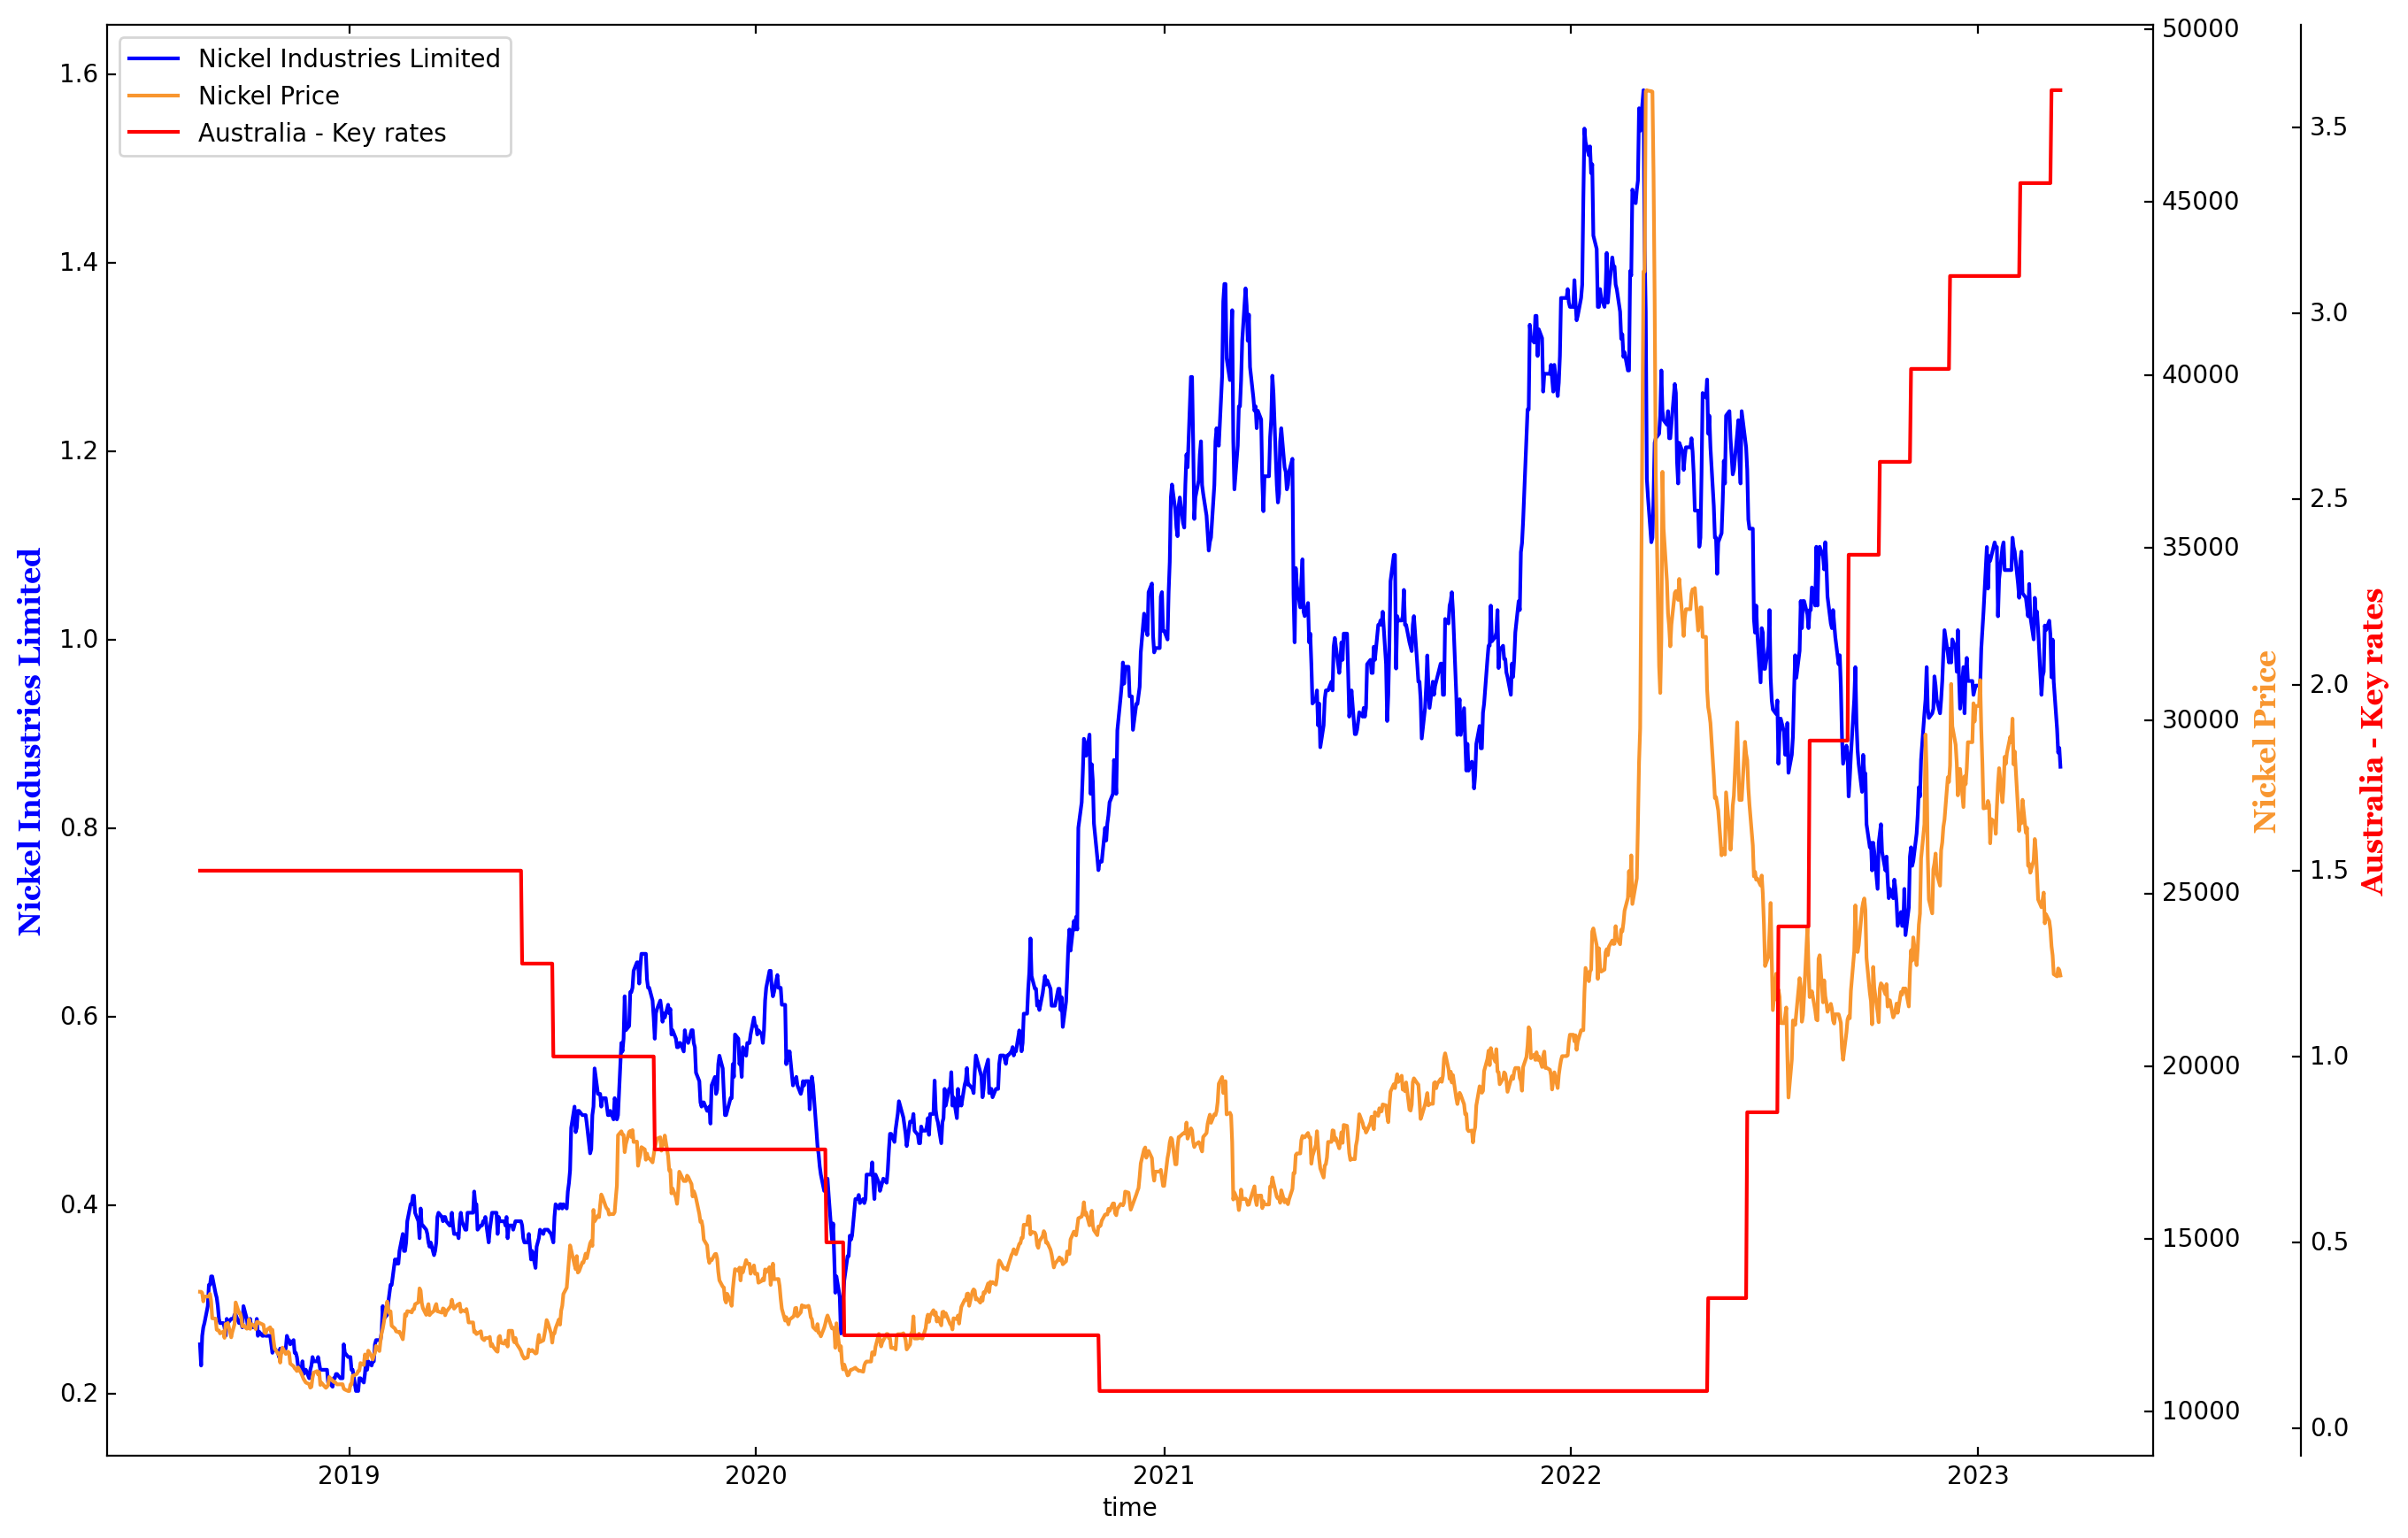

In [8]:
plot_nick_rate_nic(nickel_df, rates, nic_df)

In [9]:
data = union_data_in_one_df(nickel_df, rates, nic_df)


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    NIC   No. Observations:                 1110
Model:                 ARIMA(4, 1, 1)   Log Likelihood                2432.560
Date:                Sun, 19 Mar 2023   AIC                          -4849.120
Time:                        21:54:33   BIC                          -4809.030
Sample:                    08-20-2018   HQIC                         -4833.960
                         - 11-18-2022                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Nickle price  4.858e-06   8.92e-07      5.445      0.000    3.11e-06    6.61e-06
Rate            -0.0445      0.019     -2.298      0.022      -0.082      -0.007
ar.L1            0.0354      0.861      0.04

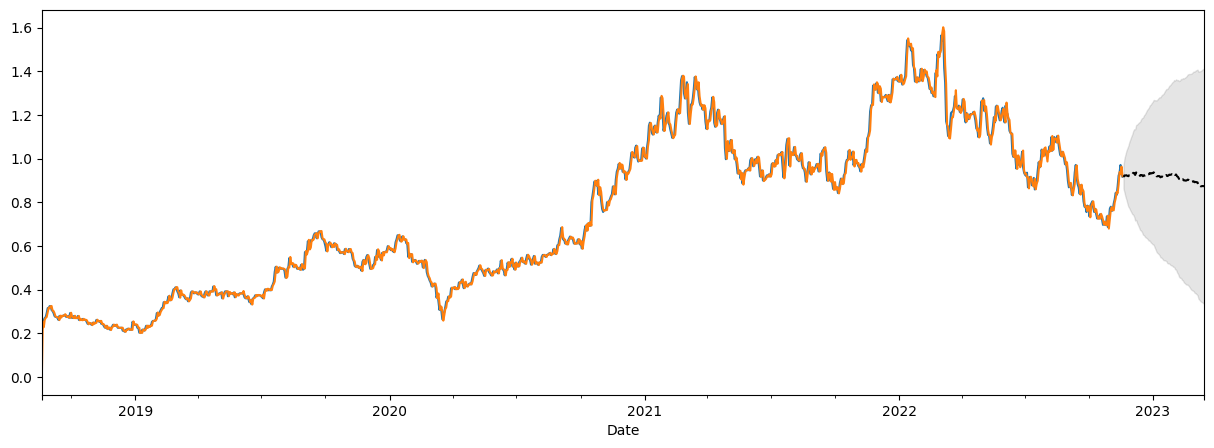

In [10]:
first_model(data)